In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
# Enter ticker, options info and portfolio info

ticker='AAPL'
strike=145
call_price=2.70
expiry='2021-02-19'

shares=6000
overwrite_tgt=0.30

#Get data
start_date='2015-12-15'
end_date='2020-12-29'
data=yf.download(ticker,start=start_date,end=end_date)
last=data['Adj Close'][-1]

[*********************100%***********************]  1 of 1 completed


In [3]:
# Organize data and calculate variables
port_val=shares*last

otm_pct=np.round((strike-last)/last,4)*100

ow_shares=int(round(shares*overwrite_tgt,-2))
overwrite=np.round(ow_shares/shares,4)
cash_flow=int(ow_shares*call_price)
cf_pct=np.round(cash_flow/(last*shares),4)*100

recent=data.loc['2020':]
ath=round(data['Adj Close'].max(),2)
ath_date=data['Adj Close'].idxmax()

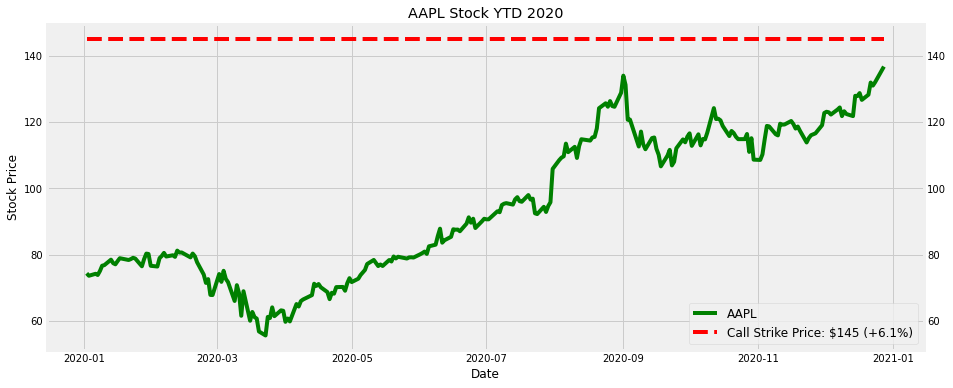

In [4]:
############ Stock Chart with Strike Price ##################

plt.figure(figsize=(14,6))
plt.plot(recent['Adj Close'],color='green',label=ticker)
plt.tick_params(labeltop=False,labelright=True)
plt.hlines(y=strike,xmin=recent.index[0],xmax=recent.index[-1],
          linestyle='dashed',color='red',
          label='Call Strike Price: ${} (+{:.1f}%)'.format(strike,otm_pct))
plt.title('{} Stock YTD 2020'.format(ticker))
plt.legend(loc='lower right',fontsize=12)
plt.xlabel('Date')
plt.ylabel('Stock Price')

############ Add optional annotations ##############

# plt.annotate('All time high close (${})'.format(ath),xy=(ath_date,data['Adj Close'].loc[ath_date]),xytext=(-300,10),
#             textcoords='offset points',arrowprops=dict(facecolor='black',shrink=0.05),
#             weight='bold',size=12,color='black')


# plt.annotate('Earnings',xy=('2020-10-22',data['Adj Close'].loc['2020-10-22']),xytext=(30,40),
#             textcoords='offset points',arrowprops=dict(facecolor='black',shrink=0.05),
#             weight='bold',size=12,color='black')


####################################################

plt.savefig('{} YTD with Call Strike.png'.format(ticker))

plt.show();

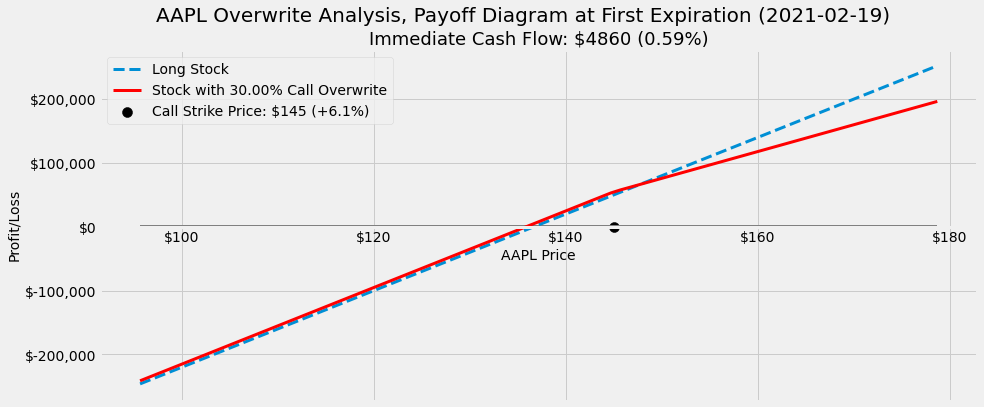

In [8]:
up_dn=0.3
skip=1
stock_range=np.arange((1-up_dn)*last,((1+up_dn)*last)+1,skip)

# Caluclate P&L from stock, short call and covered call
#long stock
stock_pl=(stock_range-last)*shares 
#short call
call_pl=np.where(stock_range>strike,((strike-stock_range)+call_price)*ow_shares,call_price*ow_shares)
#covered call
covd_call_pl=stock_pl+call_pl

# create visualization

plt.style.use('fivethirtyeight')

fig,ax=plt.subplots(figsize=(14,6))
ax.spines['bottom'].set_position('zero')

plt.plot(stock_range,stock_pl,label='Long Stock',lw=3,ls='dashed')
plt.plot(stock_range,covd_call_pl,label='Stock with {:.2f}% Call Overwrite'.format(overwrite*100,0),color='red',lw=3)
plt.scatter(strike,0,label='Call Strike Price: ${} (+{:.1f}%)'.format(strike,otm_pct),s=100,color='black')

plt.hlines(y=0,xmin=stock_range.min(),xmax=stock_range.max(),color='gray')

plt.ylabel('Profit/Loss',fontsize=14)
plt.yticks(fontsize=14)
plt.gca().yaxis.set_major_formatter('${x:,.0f}')
plt.xlabel('{} Price'.format(ticker),fontsize=14)
plt.xticks(fontsize=14)
plt.gca().xaxis.set_major_formatter('${x:,.0f}')

plt.suptitle('{} Overwrite Analysis, Payoff Diagram at First Expiration ({})'.format(ticker,expiry),fontsize=20)
plt.title('Immediate Cash Flow: ${:02d} ({:.2f}%)'.format(cash_flow,cf_pct),fontsize=18)

plt.legend(loc='best',fontsize=14)

plt.savefig('{} Overwrite Payoff Diagram.png'.format(ticker))

plt.show()

In [9]:
# Create DataFrame of Stock Prices every 5%
pct_range=1+np.arange(-0.30,0.31,0.05)
percent_range=pct_range*last
# Caluclate P&L from stock, short call and covered call
#long stock
stock_pl_5=(percent_range-last)*shares 
#short call
call_pl_5=np.where(percent_range>strike,((strike-percent_range)+call_price)*ow_shares,call_price*ow_shares)
#covered call
covd_call_pl_5=stock_pl_5+call_pl_5
ret=pct_range-1

df=pd.DataFrame({'return':ret,'cvd_call':covd_call_pl_5/port_val,'stock':stock_pl_5/port_val})
df.set_index('return',inplace=True)
df=df.T
df.to_excel('{} Covered Call Returns.xlsx'.format(ticker))

In [10]:
last

136.69000244140625